# Dataset analysis

### Visualization of content

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

### Class distribution

### Dimension overview

https://www.kaggle.com/code/faldoae/exploratory-data-analysis-eda-for-image-datasets

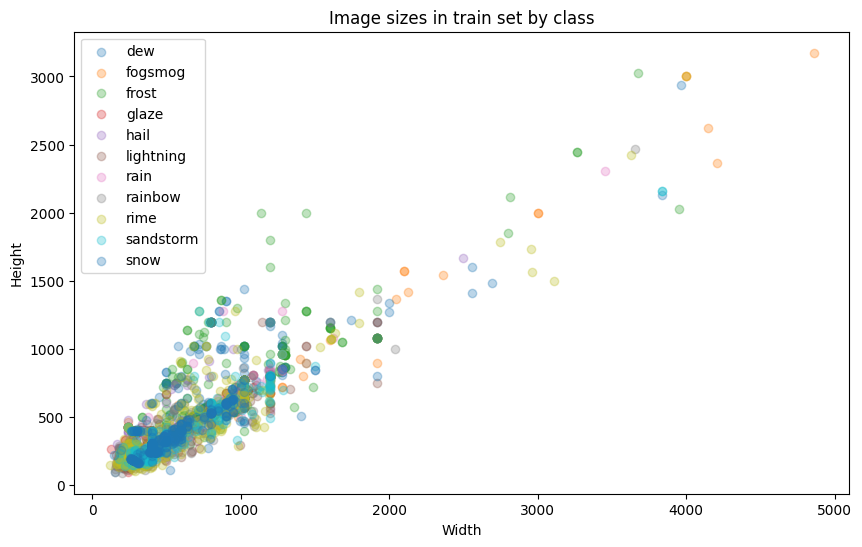

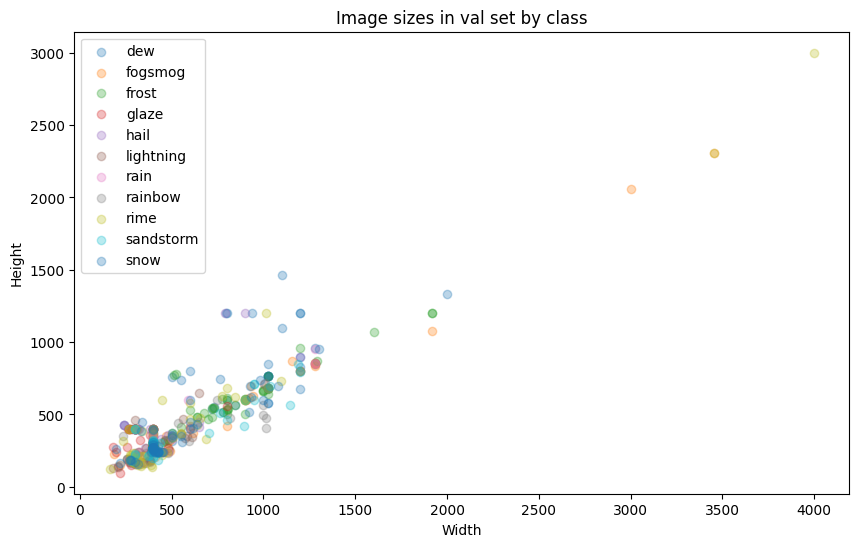

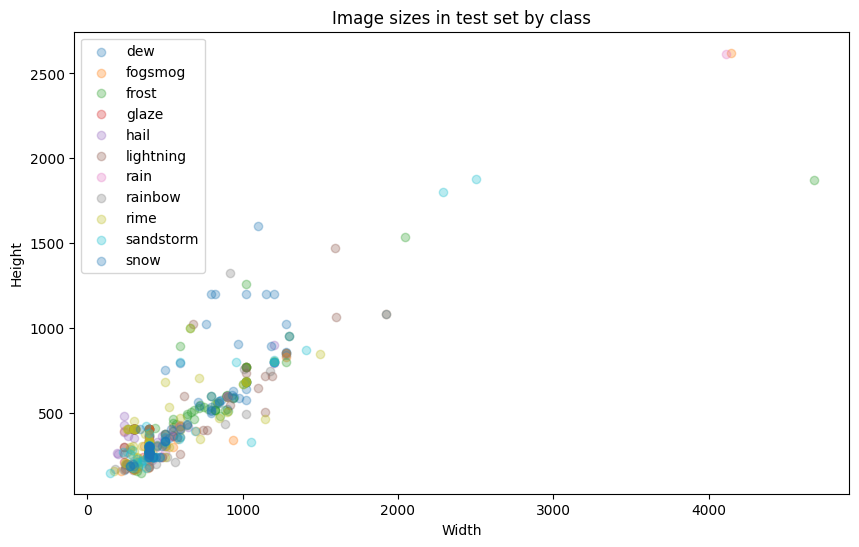

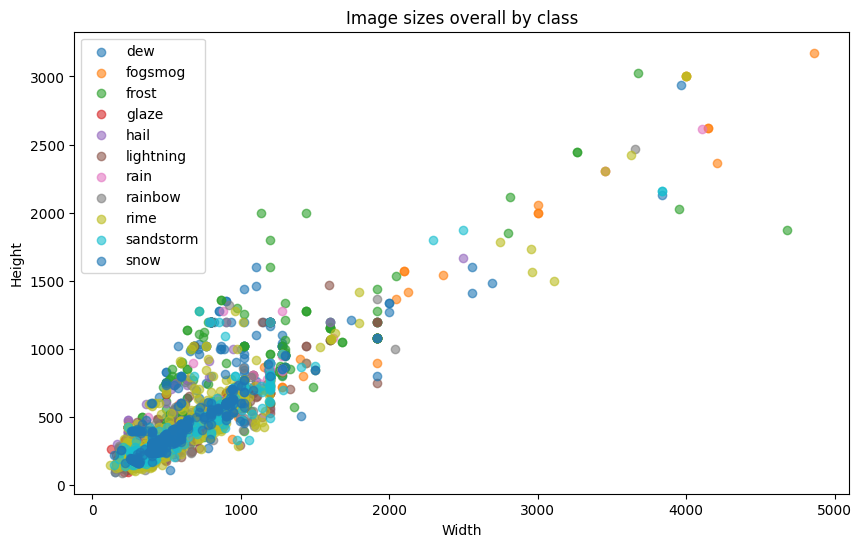

In [14]:
def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if len(arr.shape) == 3:
        h, w, _ = arr.shape  # color image
    else:
        h, w = arr.shape     # grayscale image
    return h,w

def collect_image_sizes(data_folder):
    sizes = {}  # {split: {class: [(h,w), ...]}}
    overall = {}  # {class: [(h,w), ...]} disregarding split

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_folder, split)
        sizes[split] = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png','jpg','jpeg'))]
            class_sizes = [get_dims(f) for f in files]
            sizes[split][class_name] = class_sizes

            if class_name not in overall:
                overall[class_name] = []
            overall[class_name].extend(class_sizes)

    return sizes, overall


def plot_sizes(sizes, overall):
    # 1. Plot by split and class
    for split, split_data in sizes.items():
        plt.figure(figsize=(10,6))
        for class_name, dims in split_data.items():
            heights = [h for h,w in dims]
            widths = [w for h,w in dims]
            plt.scatter(widths, heights, label=class_name, alpha=0.3)
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title(f"Image sizes in {split} set by class")
        plt.legend()
        plt.show()

    # 2. Overall plot by class
    plt.figure(figsize=(10,6))
    for class_name, dims in overall.items():
        heights = [h for h,w in dims]
        widths = [w for h,w in dims]
        plt.scatter(widths, heights, label=class_name, alpha=0.6)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image sizes overall by class")
    plt.legend()
    plt.show()

# Usage:
data_folder = "../data"  # your structured folder
sizes, overall = collect_image_sizes(data_folder)
plot_sizes(sizes, overall)

### Color analysis / Mean image